### Goals
In this notebook I built a generator that can be used to help create data to train a classifier. There are many cases where this might be useful. If you are interested in any of these topics, you are welcome to explore the linked papers and articles!

-   With smaller datasets, GANs can provide useful data augmentation that substantially [improve classifier performance](https://arxiv.org/abs/1711.04340).
-   You have one type of data already labeled and would like to make predictions on [another related dataset for which you have no labels](https://www.nature.com/articles/s41598-019-52737-x). (You'll learn about the techniques for this use case in future notebooks!)
-   You want to protect the privacy of the people who provided their information so you can provide access to a [generator instead of real data](https://www.ahajournals.org/doi/full/10.1161/CIRCOUTCOMES.118.005122).
-   You have [input data with many missing values](https://arxiv.org/abs/1806.02920), where the input dimensions are correlated and you would like to train a model on complete inputs.
-   You would like to be able to identify a real-world abnormal feature in an image [for the purpose of diagnosis](https://link.springer.com/chapter/10.1007/978-3-030-00946-5_11), but have limited access to real examples of the condition.

## Initializations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def show_tensor_images(tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
  image_tensor = (tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  if show:
    plt.show()

## Helper Functions

In [3]:
def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
    y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    return torch.cat([x, y], 1)

def get_one_hot_labels(labels, n_classes):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?)
    Parameters:
    labels: (n_samples, 1)
    n_classes: a single integer corresponding to the total number of classes in the dataset
    '''
    return F.one_hot(labels, n_classes)

## Generator

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (CIFAR100 is in color (red, green, blue), so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

## Discriminator

In [5]:
class Discriminator(nn.Module):
  def __init__(self, im_chan, hidden_dim=64):
    super().__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan, hidden_dim, kernel_size=4, stride=1),
        self.make_disc_block(hidden_dim, hidden_dim*2, kernel_size=4, stride=2),
        self.make_disc_block(hidden_dim*2, hidden_dim*4, kernel_size=4, stride=2),
        self.make_disc_block(hidden_dim*4, 1, kernel_size=4, stride=2, final_layer=True)
    )

  def make_disc_block(self, in_chan, out_chan, kernel_size=4, stride=2, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride),
      )
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride),
          nn.BatchNorm2d(out_chan),
          nn.LeakyReLU(0.2, inplace=True)
      )

  def forward(self, x):
    x = self.disc(x).view(len(x), -1)
    return x

## Classifier

In [6]:
class Classifier(nn.Module):
  def __init__(self, im_chan, n_classes, hidden_dim=32):
    super().__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan, hidden_dim),
        self.make_disc_block(hidden_dim, hidden_dim*2),
        self.make_disc_block(hidden_dim*2, hidden_dim*4),
        self.make_disc_block(hidden_dim*4, n_classes, final_layer=True)
    )

  def make_disc_block(self, in_chan, out_chan, kernel_size=3, stride=2, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride),
      )
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_chan, out_chan, kernel_size, stride),
          nn.BatchNorm2d(out_chan),
          nn.LeakyReLU(0.2, inplace=True)
      )

  def forward(self, x):
    x = self.disc(x).view(len(x), -1)
    return x

## Hyperparameters

In [7]:
cifar100_shape = (3, 32, 32)
n_classes = 100

In [8]:
n_epochs = 1000
batch_size = 64
lr = 0.0002
display_step = 500
z_dim = 64
device = 'cuda'

In [9]:
generator_input_dim = z_dim + n_classes
disc_input_dim = n_classes + cifar100_shape[0]

## Training Classifier and the Generator
I used pre-trained classifier and generator. If you want to train the classifier and generator yourself, first create a dataloader for cifar100, and then run the following 2 functions.

In [19]:
dataloader = None  # CHANGE ME

In [11]:
def train_generator():
  gen = Generator(generator_input_dim).to(device)
  gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
  disc = Discriminator(disc_input_dim).to(device)
  disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
      torch.nn.init.normal_(m.weight, 0.0, 0.02)
      torch.nn.init.constant_(m.bias, 0)

  gen = gen.apply(weights_init)
  disc = disc.apply(weights_init)

  criterion = nn.BCEWithLogitsLoss()

  cur_step = 0
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  for epoch in range(n_epochs):
    for real, labels in dataloader:
      cur_batch = len(real)

      # Train Discriminator
      disc_opt.zero_grad()

      real = real.to(device)  # (B, C, H, W)
      labels = labels.to(device)
      one_hot_labels = get_one_hot_labels(labels, n_classes).float()
      image_one_hot_labels = one_hot_labels[:, :, None, None]
      image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar100_shape[1], cifar100_shape[2])  # (B, Classes, H, W)
      real_image_plus_labels = combine_vectors(real, image_one_hot_labels)  # (B, C + Classes, H, W)

      noise = generate_noise(cur_batch, z_dim, device=device)
      noise_plus_labels = combine_vectors(noise, one_hot_labels)
      fake_images = gen(noise_plus_labels)
      fake_images_plus_labels = combine_vectors(fake_images.detach(), image_one_hot_labels)

      disc_pred_real = disc(real_image_plus_labels)
      disc_pred_fake = disc(fake_images_plus_labels)

      disc_loss_real = criterion(disc_pred_real, torch.ones_like(disc_pred_real))
      disc_loss_fake = criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake))
      disc_loss = (disc_loss_real + disc_loss_fake) / 2
      disc_loss.backward(retain_graph=True)
      disc_opt.step()

      mean_discriminator_loss += disc_loss.item() /  display_step

      # Train Generator
      gen_opt.zero_grad()

      fake_images_plus_labels = combine_vectors(fake_images, image_one_hot_labels)
      disc_pred_fake = disc(fake_images_plus_labels)
      gen_loss = criterion(disc_pred_fake, torch.ones_like(disc_pred_fake))
      gen_loss.backward()
      gen_opt.step()

      mean_generator_loss += gen_loss.item() / display_step

      # Show Statistics
      if cur_step % display_step == 0 and cur_step > 0:
        print(f'Epoch: {epoch}\tStep: {cur_step}\tGenerator Loss: {mean_discriminator_loss}\tDiscriminator Loss: {mean_discriminator_loss}')
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        show_tensor_images(real)
        show_tensor_images(fake_images)

      cur_step += 1

In [12]:
def train_classifier():
  n_epochs = 10
  batch_size = 512
  lr = 0.0002
  cur_step = 0
  display_step = 10

  criterion = nn.CrossEntropyLoss()
  classifier = Classifier(cifar100_shape[0], n_classes)
  classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)

  for epoch in n_epochs:
    for images, labels in tqdm(dataloader):
      cur_batch_size = len(images)
      images = images.to(device)
      labels = labels.to(device)

      classifier_opt.zero_grad()

      predictions = classifier(images.detach())
      loss = criterion(predictions, labels)
      loss.backward()
      classifier_opt.step()

      if cur_step % display_step == 0 and cur_step > 0:
        num_validation = 0
        classifier_val_loss = 0
        classifier_correct = 0
        for val_example, val_label in tqdm(val_dataloader):
          cur_batch_size = len(val_example)
          num_validation += cur_batch_size
          val_example = val_example.to(device)
          val_label = val_label.to(device)

          val_pred = classifier(val_example)

          classifier_val_loss += criterion(val_pred, val_label) * cur_batch_size
          classifier_correct  += (val_pred.argmax(1) == val_label).float().sum()

        print(f"Step: {cur_step}\t"
              f"Classifier Loss: {classifier_val_loss}\t"
              f"Number of Validations: {num_validation}"
              f"Correct Validations: {classifier_correct}"
              )

      cur_step += 1

## Combine real and fake samples

In [13]:
def combine_sample(real, fake, p_real):
  make_fake = torch.rand(len(real)) > p_real
  target_images = real.clone()
  target_images[make_fake] = fake[make_fake]
  return target_images

## Finetuning
Here, I finetune the classifier on combined i.e, real as well as fake, data.

In [18]:
def find_optimal():
    gen_names = [
        "/content/gen_1.pt",
        "/content/gen_2.pt",
        "/content/gen_3.pt",
        "/content/gen_4.pt"
    ]

    best_p_real, best_gen_name = 0.6, gen_names[1]
    return best_p_real, best_gen_name

def augmented_train(p_real, gen_name):
    gen = Generator(generator_input_dim).to(device)
    gen.load_state_dict(torch.load(gen_name))

    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier.load_state_dict(torch.load("/content/class.pt"))
    criterion = nn.CrossEntropyLoss()
    batch_size = 256

    train_set = torch.load("/content/insect_train.pt")
    val_set = torch.load("/content/insect_val.pt")
    dataloader = DataLoader(
        torch.utils.data.TensorDataset(train_set["images"], train_set["labels"]),
        batch_size=batch_size,
        shuffle=True
    )
    validation_dataloader = DataLoader(
        torch.utils.data.TensorDataset(val_set["images"], val_set["labels"]),
        batch_size=batch_size
    )

    display_step = 1
    lr = 0.0002
    n_epochs = 20
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    best_score = 0
    for epoch in range(n_epochs):
        for real, labels in dataloader:
            real = real.to(device)
            # Flatten the image
            labels = labels.to(device)
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            ### Update classifier ###
            # Get noise corresponding to the current batch_size
            classifier_opt.zero_grad()
            cur_batch_size = len(labels)
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            target_images = combine_sample(real.clone(), fake.clone(), p_real)
            labels_hat = classifier(target_images.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            # Calculate the accuracy on the validation set
            if cur_step % display_step == 0 and cur_step > 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                with torch.no_grad():
                    for val_example, val_label in validation_dataloader:
                        cur_batch_size = len(val_example)
                        num_validation += cur_batch_size
                        val_example = val_example.to(device)
                        val_label = val_label.to(device)
                        labels_hat = classifier(val_example)
                        classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                        classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()
                    accuracy = classifier_correct.item() / num_validation
                    if accuracy > best_score:
                        best_score = accuracy
            cur_step += 1
    return best_score

def eval_augmentation(p_real, gen_name, n_test=20):
    total = 0
    for i in range(n_test):
        total += augmented_train(p_real, gen_name)
    return total / n_test

best_p_real, best_gen_name = find_optimal()
performance = eval_augmentation(best_p_real, best_gen_name)
print(f"Your model had an accuracy of {performance:0.1%}")

Your model had an accuracy of 48.7%


## Observing model accuracy after finetuning with different p_real values

  0%|          | 0/21 [00:00<?, ?it/s]

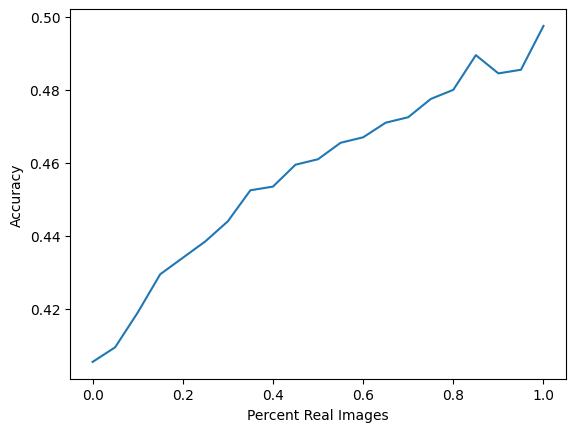

In [ ]:
accuracies = []
p_real_all = torch.linspace(0, 1, 21)
for p_real_vis in tqdm(p_real_all):
    accuracies += [eval_augmentation(p_real_vis, best_gen_name, n_test=4)]
plt.plot(p_real_all.tolist(), accuracies)
plt.ylabel("Accuracy")
_ = plt.xlabel("Percent Real Images")

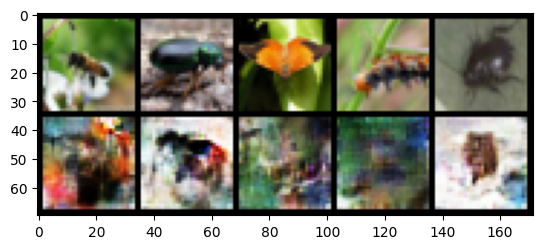

In [ ]:
examples = [4, 41, 80, 122, 160]
train_images = torch.load("insect_train.pt")["images"][examples]
train_labels = torch.load("insect_train.pt")["labels"][examples]

one_hot_labels = get_one_hot_labels(train_labels.to(device), n_classes).float()
fake_noise = get_noise(len(train_images), z_dim, device=device)
noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
gen = Generator(generator_input_dim).to(device)
gen.load_state_dict(torch.load(best_gen_name))

fake = gen(noise_and_labels)
show_tensor_images(torch.cat([train_images.cpu(), fake.cpu()]))